In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
df1 = pd.read_csv('./Data/Lab_Data/front_door_group_records.csv')
df2 = pd.read_csv('./Data/Lab_Data/back_door_group_records.csv')
df3 = pd.read_csv('./Data/Lab_Data/motion_group_records.csv')
df4 = pd.read_csv('./Data/Lab_Data/actuator_records.csv')

#original_df = df1.copy() #Keep a copy to compare
## Toggle the values of Light Sensor.
df3.loc[df3['sensor_name'] == 'Light Sensor', 'state'] = 1 - df3['state']

combined_lab_data = pd.concat([df1, df2, df3, df4], ignore_index=True)
# Convert the 'datetime' column to a datetime data type if necessary
combined_lab_data['datetime'] = pd.to_datetime(combined_lab_data['seconds'], unit='s')
# combined_office_data['datetime'] = pd.to_datetime(combined_office_data['date'] + ' ' + combined_office_data['time'], format='%d/%m/%y %H:%M')

# Sort by the 'datetime' column
combined_lab_data = combined_lab_data.sort_values(by='datetime')

# Display the sorted, combined DataFrame
# combined_lab_data.to_csv('./Data/Lab_Data/Combined_Lab_Data.csv')
print(combined_lab_data.head)

<bound method NDFrame.head of             date   time       seconds  state    sensor_name   thing_name  \
0       04/25/24  10:21  1.714059e+09    1.0  Motion Sensor  FrontDoorPi   
1       04/25/24  10:21  1.714059e+09    0.0  Motion Sensor  FrontDoorPi   
2       04/25/24  10:22  1.714059e+09    1.0  Motion Sensor  FrontDoorPi   
3       04/25/24  10:22  1.714059e+09    0.0  Motion Sensor  FrontDoorPi   
4       04/25/24  10:24  1.714059e+09    1.0  Motion Sensor  FrontDoorPi   
...          ...    ...           ...    ...            ...          ...   
265213  10/01/24  16:29  1.727818e+09    0.0   Sonar Sensor  FrontDoorPi   
265214  10/01/24  16:29  1.727818e+09    1.0   Sonar Sensor  FrontDoorPi   
265215  10/01/24  16:29  1.727818e+09    0.0   Sonar Sensor  FrontDoorPi   
265216  10/01/24  16:29  1.727818e+09    1.0  Motion Sensor  FrontDoorPi   
265217  10/01/24  16:29  1.727818e+09    0.0  Motion Sensor  FrontDoorPi   

             thing_ip                      datetime  
0  

In [6]:
combined_lab_data = combined_lab_data.set_index('datetime') #make the date column as index

# combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
# print(combined_office_data.size, combined_office_data_filtered.size)
lab_hourly = combined_lab_data.state.resample('1h').sum() #resample on hourly basis and get summary of sensor values on 2 hours.

lab_hourly = lab_hourly.between_time('09:00', '18:00')
lab_hourly = lab_hourly.reset_index()

print(lab_hourly.head)

<bound method NDFrame.head of                 datetime  state
0    2024-04-25 15:00:00   29.0
1    2024-04-25 16:00:00   60.0
2    2024-04-25 17:00:00   35.0
3    2024-04-25 18:00:00   78.0
4    2024-04-26 09:00:00   23.0
...                  ...    ...
1589 2024-10-01 14:00:00   17.0
1590 2024-10-01 15:00:00   70.0
1591 2024-10-01 16:00:00   77.0
1592 2024-10-01 17:00:00   41.0
1593 2024-10-01 18:00:00   75.0

[1594 rows x 2 columns]>


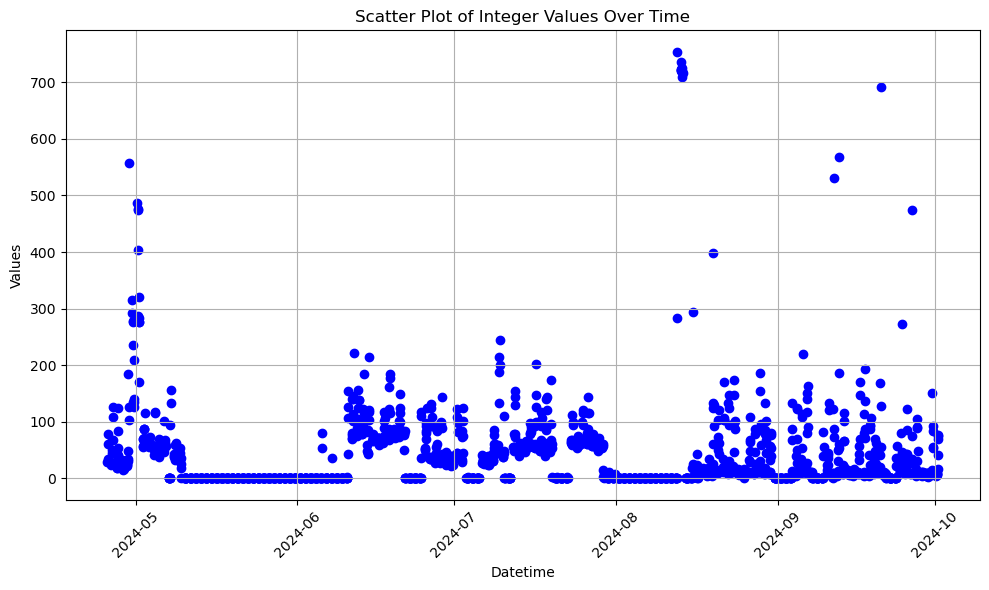

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(lab_hourly['datetime'], lab_hourly['state'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

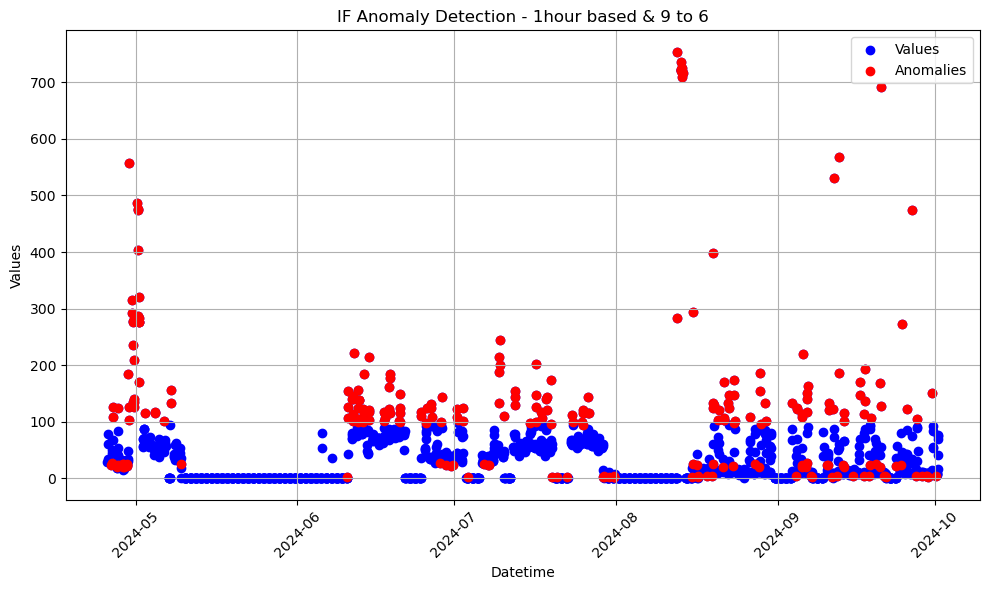

Total anomalies: 260, Percentage of anomalous values: 16.311166875784192%
                datetime  state  anomaly
0    2024-04-25 15:00:00   29.0        1
1    2024-04-25 16:00:00   60.0        1
2    2024-04-25 17:00:00   35.0        1
3    2024-04-25 18:00:00   78.0        1
7    2024-04-26 12:00:00   50.0        1
...                  ...    ...      ...
1589 2024-10-01 14:00:00   17.0        1
1590 2024-10-01 15:00:00   70.0        1
1591 2024-10-01 16:00:00   77.0        1
1592 2024-10-01 17:00:00   41.0        1
1593 2024-10-01 18:00:00   75.0        1

[687 rows x 3 columns]
                datetime  state  anomaly
0    2024-04-25 15:00:00   29.0        1
1    2024-04-25 16:00:00   60.0        1
2    2024-04-25 17:00:00   35.0        1
3    2024-04-25 18:00:00   78.0        1
7    2024-04-26 12:00:00   50.0        1
...                  ...    ...      ...
1589 2024-10-01 14:00:00   17.0        1
1590 2024-10-01 15:00:00   70.0        1
1591 2024-10-01 16:00:00   77.0        1


In [8]:
from sklearn.ensemble import IsolationForest

# lab_hourly['datetime'] = pd.to_datetime(lab_hourly['datetime'])

# Prepare data for IsolationForest
values = lab_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination='auto', random_state=42)
lab_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = lab_hourly[lab_hourly['anomaly'] == -1]
non_anomalies = lab_hourly[lab_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(lab_hourly['datetime'], lab_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - 1hour based & 9 to 6')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_2H.png')
plt.show()


count_anomaly_h = (lab_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(lab_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

# non_anomalies.to_csv('./Output_CSV/regular_office.csv', index=False)
# anomalies.to_csv('./Output_CSV/anomaly_office.csv', index=False)
lab_hourly.to_csv('./Output_CSV/lab_data/IF_lab_anomaly_1h_9to6.csv', index=False)